# Company Bankruptcy Prediction


Kaggle competition link: https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

Kaggle Challenge information:
The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange. The challenge is to predict whether a company will go bankrupt.

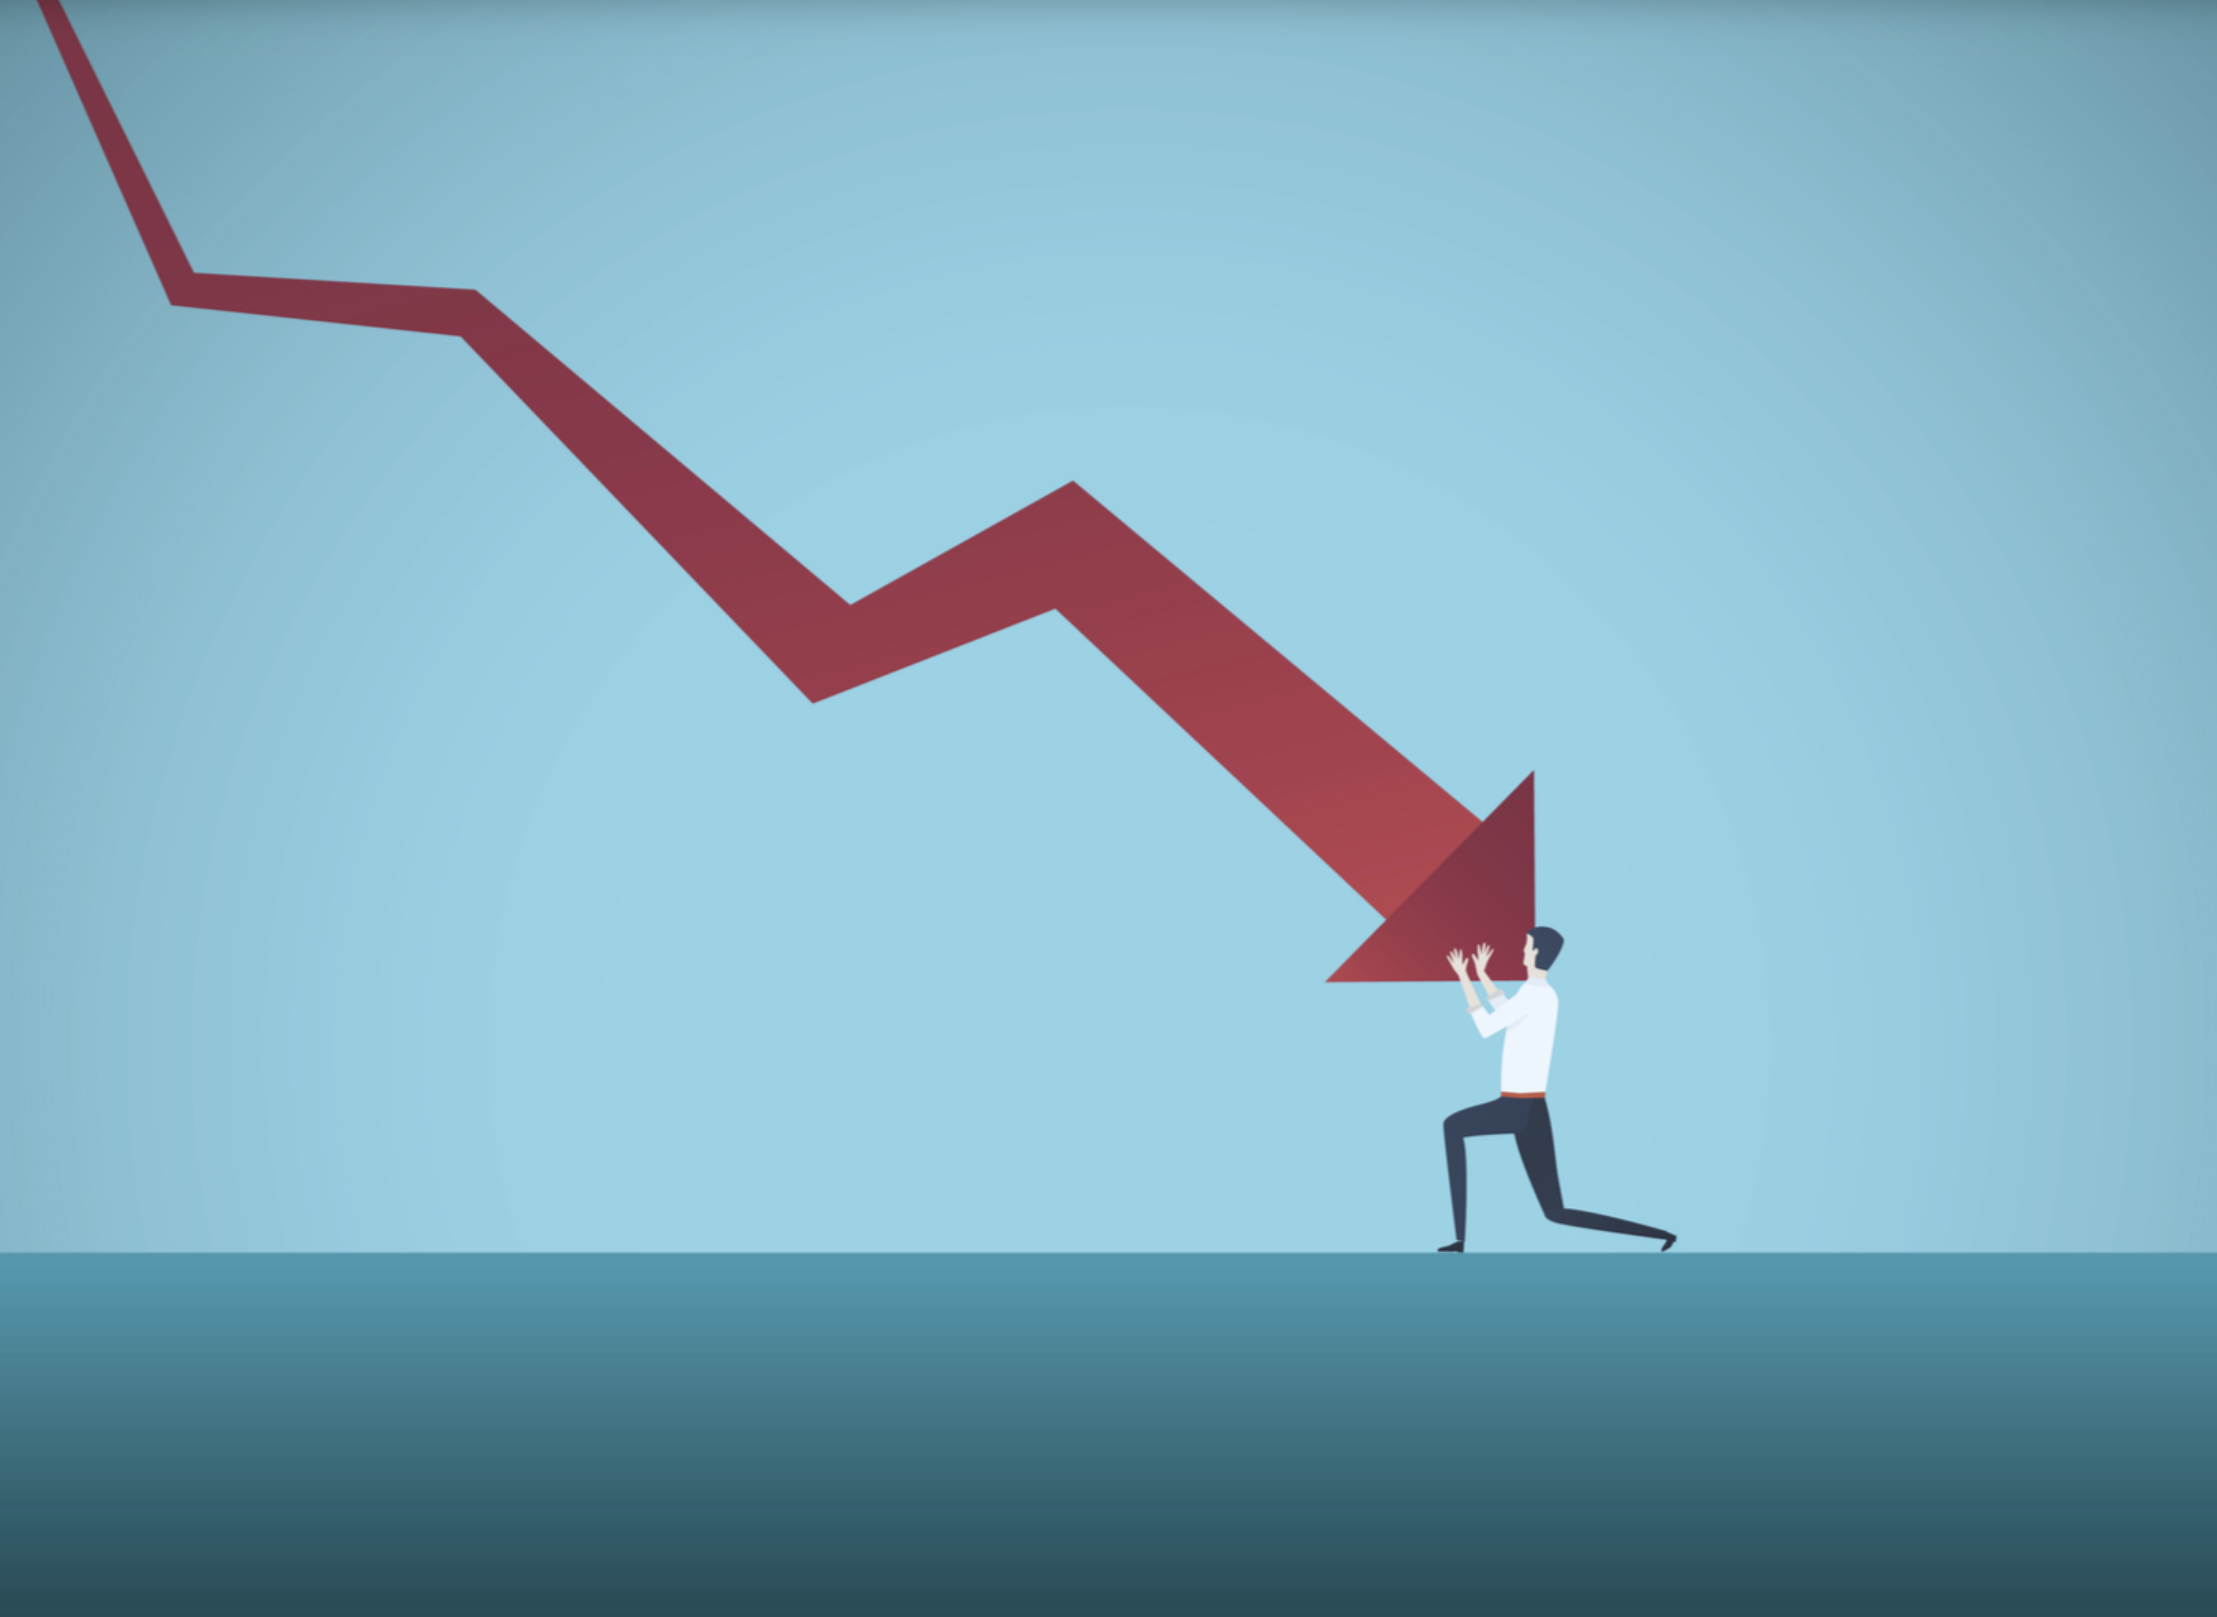

I'd like to give credit to the following notebooks that helped guide me a long the way
- https://www.kaggle.com/agarohit/bankruptcy-prediction-accuracy-99/notebook
- https://www.kaggle.com/kundankumarmandal/company-bankruptcy-prediction-96-accuracy

In this assignment I tested the following models: Extra Trees, SVM, KNN, Random Forest, Gradient Boosting Trees, Logistic Regression, and Naive Bayes. 

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

# EDA

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

At first glance, some columns seem to be normalized. For example, it would not make sense for a business to have a decimal figure for net worth/assets.

In [3]:
df.shape

(6819, 96)

In [4]:
#check for null values
print(df.isnull().sum().sum())

0


<AxesSubplot:>

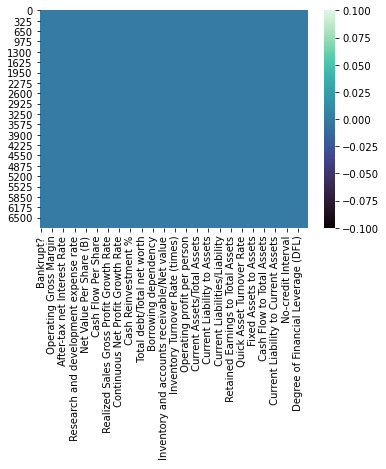

In [5]:
sns.heatmap(df.isnull(), cmap='mako')

Thank you kaggle and their relatively clean datasets, this one has no null records! Although, it would not have mattered for tree based algorithms.

### Visualizations

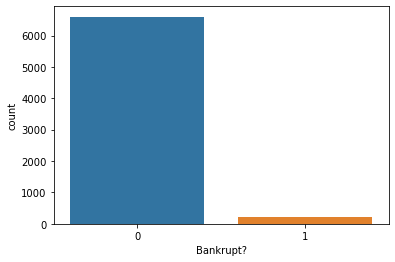

0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

In [113]:
#out of the entire data set how many were declared bankrupt?

sns.countplot(data = df, x='Bankrupt?')
plt.show()
df['Bankrupt?'].value_counts(normalize=True)

In [7]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

When Exploring the data I noticed that some columns could not be read by Seaborn. I figured that it might be because of leading/ trailing spaces in the column titles. After the code below, it's evident that there was leading/trailing spaces and seaborn is now properly able to interpret the data for visualizations

In [8]:
df_col = []
for i in range(len(df.columns)):
    df_col.append(str(df.columns[i]).strip())
    
df.columns = df_col

While exploring the data I noticed that Net Income Flag has only one value, let's get rid of this column


In [9]:
df = df.drop(['Net Income Flag'], axis=1)

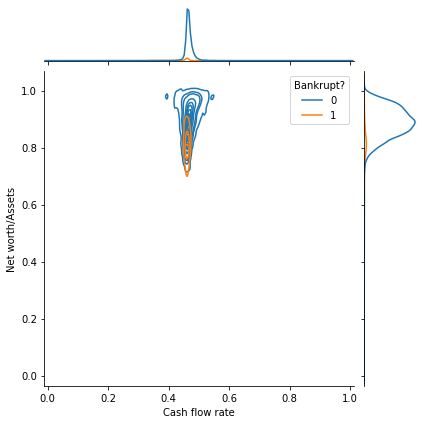

In [10]:
sns.jointplot(
    data=df,
    x="Cash flow rate", y="Net worth/Assets", hue="Bankrupt?",
    kind="kde")

The cash flow rate of a business is a key indicator for businesses to go bankrupt. Interestingly the plot above shows that the majority of the businesses in the data set had a relatively similar cash flow rate. A little unsuprisingly, the businesses that went bankrupt have less net worth/ assets compared to the bankrupt ones.

This chart also reinforces our findings from earlier, with the bar chart, that our data is highly imbalanced. We'll have to keep this in mind to later transform the data.

Setup for correlation matrix

In [114]:
dependent = df['Bankrupt?']
corrdep = df.corrwith(dependent, axis = 0)
# corrdep.sort_values()

xtest = corrdep.sort_values()
type(xtest)
order =[]
for x,z in xtest.items():
    order.append(x)
    
dfviz = df.copy()

dfviz_ordered = dfviz.reindex(columns = order)

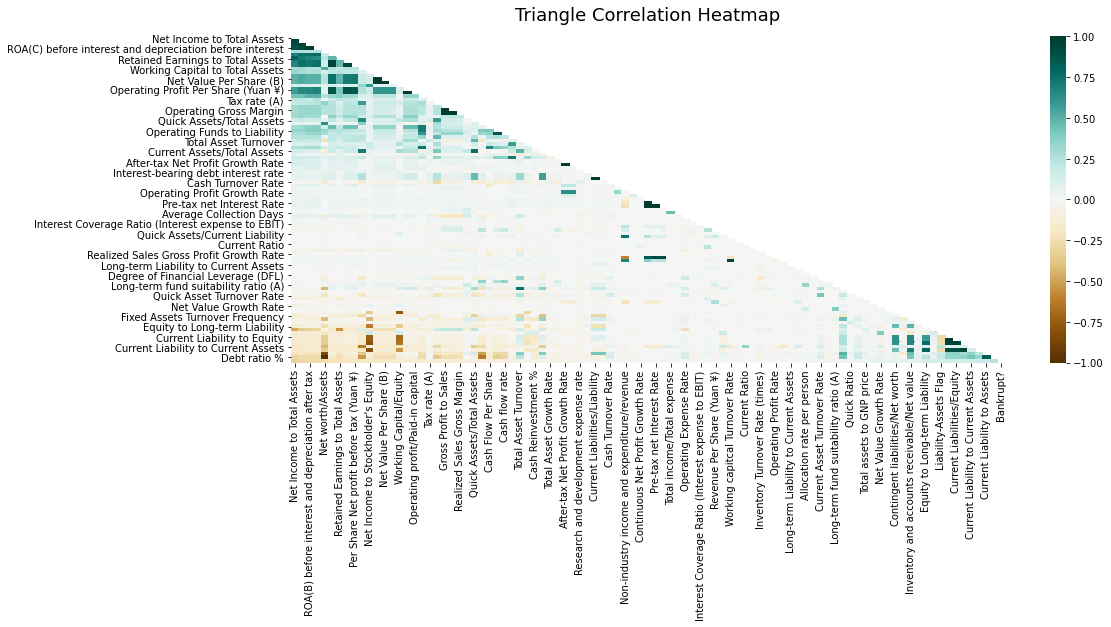

In [12]:
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(dfviz_ordered.corr(), dtype=np.bool))

heatmap = sns.heatmap(dfviz_ordered.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')

heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

The above chart hints at multicolinearity for quite a few columns, let's check to hopefully drop a few


In [13]:
corr_mat = df.corr()

upper_corr_mat = corr_mat.where(
    np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
  
# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values()
print(sorted_mat[sorted_mat >.9])

#above I only returned the pairs above .9 correlation, but more exploration uncovered that there is a lot of multicolinearity
#between columns

#let's get these columns in a list to drop

Net Income to Total Assets                         ROA(B) before interest and depreciation after tax          0.912040
Continuous interest rate (after tax)               Operating Profit Rate                                      0.915544
Pre-tax net Interest Rate                          Operating Profit Rate                                      0.916448
ROA(A) before interest and % after tax             ROA(C) before interest and depreciation before interest    0.940124
Cash Flow to Sales                                 Working capitcal Turnover Rate                             0.948194
Per Share Net profit before tax (Yuan ¥)           Persistent EPS in the Last Four Seasons                    0.955591
ROA(B) before interest and depreciation after tax  ROA(A) before interest and % after tax                     0.955741
Liability to Equity                                Borrowing dependency                                       0.955857
Net profit before tax/Paid-in capital           

In [14]:
#show strongly correlated negative pairs
corr_90 = sorted_mat[sorted_mat >.9]
corr_neg = sorted_mat[sorted_mat < -0.9]
corr_neg

Net worth/Assets  Debt ratio %   -1.0
dtype: float64

In [15]:
#list columns with high multicolinearity to delete
del_poscolumns = []

for x, y in corr_90.index:
    del_poscolumns.append(x)
    
del_negcolumns = []

for x, y in corr_neg.index:
    del_negcolumns.append(x)
    
join_cols = del_poscolumns + del_negcolumns

del_columns = []
[del_columns.append(x) for x in join_cols if x not in del_columns]

print(del_columns)
print(len(del_columns))

['Net Income to Total Assets', 'Continuous interest rate (after tax)', 'Pre-tax net Interest Rate', 'ROA(A) before interest and % after tax', 'Cash Flow to Sales', 'Per Share Net profit before tax (Yuan ¥)', 'ROA(B) before interest and depreciation after tax', 'Liability to Equity', 'Net profit before tax/Paid-in capital', 'After-tax net Interest Rate', 'Regular Net Profit Growth Rate', 'Operating profit/Paid-in capital', 'Net Value Per Share (C)', 'Net Value Per Share (A)', 'Gross Profit to Sales', 'Realized Sales Gross Margin', 'Current Liability to Liability', 'Current Liability to Equity', 'Net worth/Assets']
19


In [16]:
#drop columns from the list above
print(df.shape)

for col in del_columns:
    df = df.drop(col, axis=1)


print(df.shape)


(6819, 95)
(6819, 76)


Again, our data is heavily imbalanced because the amount of companies not listed as going bankrupt greatly exceeds the companies identified as bankrupt. Imbalanced data is commonly handled by performing SMOTE (Synthetic Minority Oversampling Technique). We'll perform this, but later we can test different methods like data duplication or downsampling/Tomek.

SMOTE is an upsampling method that uses KNN to fabricate copies of the minority data, in this case the identified bankrupt businesses. SMOTE randomly chooses a minority sample then a nearest neighbor is found and synthetic data is created between the two randomly chosen samples.

In [17]:
#split dependent variable

X=df.drop('Bankrupt?', axis=1)

y=df['Bankrupt?']
print(X.shape)
print(y.shape)

(6819, 75)
(6819,)


In [18]:
#balance data first with SMOTE then split & try correlations and visualizations

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X,y)
y_sm.value_counts()

1    6599
0    6599
Name: Bankrupt?, dtype: int64

In [115]:
#create df for visualization after smote
smote_df = pd.DataFrame()
smote_df = X_sm.copy()
smote_df['Smote bankrupt'] = y_sm

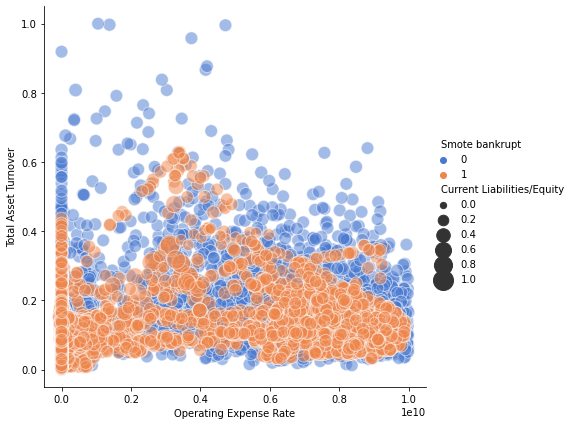

In [20]:
sns.relplot(x="Operating Expense Rate", y="Total Asset Turnover", hue="Smote bankrupt", size="Current Liabilities/Equity",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=smote_df)

We can see from the chart above that after the SMOTE transformation there is an increased amount of entries that were the minority (bankrupt). We can also see here that Total Asset Turnover seems higher for the companies that did not go bankrupt.

In [21]:
#assigment requested 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=42)

In [87]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10558, 75) (10558,) (2640, 75) (2640,)


In [23]:
y_sm.value_counts()

1    6599
0    6599
Name: Bankrupt?, dtype: int64

The value counts from above also represents that we increased the minority in the dependent variable

In [24]:
#normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#scaled for logisticregression, svm, and knn. Tree models wouldn't need it.
#although after testing my model scores, there is no effect with or without scaling for all models

In [117]:
#set up for gridsearch/ hyper parameter tuning
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','sigmoid']
        }  
    },
    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params' : {
            'C': [1,5,10],
            'solver':['lbfgs','liblinear']
        }
    },
   'KNN': {
        'model':KNeighborsClassifier(),
        'params' : {
            'n_neighbors' : [1,3,5,7],
            'algorithm':['auto','kd_tree']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,20,30,50],
            'criterion':['gini','entropy'],
            'max_depth':['None',1,2,3,5],
            'max_features':['auto','log2','sqrt']
        }
    },#testing gradient boosting trees
    'gradient_boosting_trees': {
        'model': GradientBoostingClassifier(),
        'params' : {
            'n_estimators': [10,25,50],
            'max_depth':[1,2,3,5],
            'max_features':['auto','log2','sqrt']
        }
    }, #testing extra trees model
    'extra_trees_model': {
        'model':ExtraTreesClassifier(),
        'params' : {
            "n_estimators":[10,25,50],
            'criterion':['gini','entropy'],
            'max_depth':[1,2,3,5],
            'max_features':['auto','log2','sqrt']
        }
    }
}
#got rid of 100 to try and get rid of warning... in etm,gbt, 
pd.set_option('display.max_colwidth', None)

In [118]:
X_sm = scaler.fit_transform(X_sm)
#using x_sm and y_sm for parameter tuning 
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, verbose=3, n_jobs=-1, scoring = 'recall', return_train_score=False)
    clf.fit(X_sm, y_sm)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\19046\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 180 candidates, totalling 540 fits


C:\Users\19046\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.81450108 0.87907561 0.88710454 0.88467685 0.89316383 0.89104042
 0.8546721  0.83921762 0.88134055 0.8883137  0.88119276 0.89391983
 0.81376142 0.86922437 0.89255495 0.88816232 0.89452637 0.88482775
 0.85043822 0.9022586  0.90543808 0.90695144 0.8978606  0.89907417
 0.85724682 0.88377127 0.90483195 0.89967981 0.9028617  0.89907389
 0.78223952 0.90104228 0.90604607 0.89907244 0.90725516 0.90498367
 0.89831907 0.90801535 0.91149868 0.90937761 0.91452995 0.91831735
 0.8833097  0.91589607 0.9121055  0.92453181 0.92165151 0.91816604
 0.84225275 0.91028594 0.91028691 0.90816501 0.91589379 0.91407554
 0.90559028 0.93195557 0.93983636 0.9413513  0.941654

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits


,model,best_score,best_params
0,svm,0.995454,"{'C': 20, 'kernel': 'rbf'}"
1,logistic_regression,0.915894,"{'C': 5, 'solver': 'lbfgs'}"
2,KNN,1.000000,"{'algorithm': 'auto', 'n_neighbors': 3}"
3,random_forest,0.945746,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50}"
4,gradient_boosting_trees,0.986210,"{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50}"
5,extra_trees_model,0.932412,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50}"


## Model Testing 

### SVM

In [135]:
svm = SVC(gamma='auto',C=20, kernel='rbf', probability=True)
svm.fit(X_train,y_train)
svm_pred = svm.predict(X_test)
#classification scores
print(classification_report(y_test,svm_pred))
#confusion matrix
pd.DataFrame(confusion_matrix(y_test,svm_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1334
           1       0.96      1.00      0.98      1306

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640



,0,1
0,1280,54
1,4,1302


### Logistic Regression

In [89]:
logmod = LogisticRegression(solver='liblinear',multi_class='auto', C = 5)
logmod.fit(X_train,y_train)
log_pred = logmod.predict(X_test)
#classification scores
print(classification_report(y_test,log_pred))
#confusion matrix
pd.DataFrame(confusion_matrix(y_test,log_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1334
           1       0.89      0.91      0.90      1306

    accuracy                           0.90      2640
   macro avg       0.90      0.90      0.90      2640
weighted avg       0.90      0.90      0.90      2640



,0,1
0,1192,142
1,119,1187


### KNN 

In [131]:
knn = KNeighborsClassifier(n_neighbors=2,algorithm = 'auto')
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
#classification scores
print(classification_report(y_test,knn_pred))
#confusion matrix
pd.DataFrame(confusion_matrix(y_test,knn_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1334
           1       0.95      1.00      0.97      1306

    accuracy                           0.97      2640
   macro avg       0.97      0.97      0.97      2640
weighted avg       0.97      0.97      0.97      2640



,0,1
0,1265,69
1,2,1304


Discover feature importance for KNN model

In [84]:
#perform permutation importance
results = permutation_importance(knn, X, y, scoring='neg_mean_squared_error')
# get importance
knn_importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01782
Feature: 1, Score: 0.00886
Feature: 2, Score: 0.00279
Feature: 3, Score: 0.02858
Feature: 4, Score: 0.00074
Feature: 5, Score: 0.00628
Feature: 6, Score: 0.00190
Feature: 7, Score: 0.00006
Feature: 8, Score: 0.00530
Feature: 9, Score: 0.00454
Feature: 10, Score: 0.27773
Feature: 11, Score: 0.00451
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00326
Feature: 14, Score: 0.00098
Feature: 15, Score: 0.00214
Feature: 16, Score: 0.00697
Feature: 17, Score: 0.00594
Feature: 18, Score: 0.01477
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00196
Feature: 21, Score: 0.00289
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00001
Feature: 24, Score: 0.01633
Feature: 25, Score: 0.00213
Feature: 26, Score: 0.06609
Feature: 27, Score: 0.00460
Feature: 28, Score: 0.09865
Feature: 29, Score: 0.01847
Feature: 30, Score: 0.00068
Feature: 31, Score: 0.00372
Feature: 32, Score: 0.00010
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00076
Feature: 35, Score: 0.00241
Fe

In [86]:
smote_df.iloc[:,[53,54]].head()
#so retained earnings to total assets is also an indicator

,Long-term Liability to Current Assets,Retained Earnings to Total Assets
0,0.025592,0.903225
1,0.023947,0.931065
2,0.003715,0.909903
3,0.022165,0.906902
4,0.000000,0.913850


feature 10 and 54 are key features we can tell management

### Naive Bayes

In [91]:
bayes = BernoulliNB()
bayes.fit(X_train,y_train)
bayes_pred =  bayes.predict(X_test)
#classification scores
print(classification_report(y_test,bayes_pred))
#confusion matrix
pd.DataFrame(confusion_matrix(y_test,bayes_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1334
           1       0.85      0.88      0.86      1306

    accuracy                           0.86      2640
   macro avg       0.86      0.86      0.86      2640
weighted avg       0.86      0.86      0.86      2640



,0,1
0,1129,205
1,160,1146


### Random Forest

In [132]:
forest = RandomForestClassifier(max_features = 'auto',n_estimators=50, criterion='entropy')
forest.fit(X_train,y_train)
forest_pred = forest.predict(X_test)
#classification scores
print(classification_report(y_test,forest_pred))
#confusion matrix
pd.DataFrame(confusion_matrix(y_test,forest_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1334
           1       0.96      0.99      0.97      1306

    accuracy                           0.97      2640
   macro avg       0.97      0.97      0.97      2640
weighted avg       0.97      0.97      0.97      2640



,0,1
0,1274,60
1,9,1297


### Gradient Boosting Trees

In [93]:
gbt = GradientBoostingClassifier(max_depth=5,max_features='auto',n_estimators=100)
gbt.fit(X_train,y_train)
gbt_pred = gbt.predict(X_test)
#classification scores
print(classification_report(y_test,gbt_pred))
#confusion matrix
pd.DataFrame(confusion_matrix(y_test,gbt_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1334
           1       0.96      0.99      0.97      1306

    accuracy                           0.97      2640
   macro avg       0.97      0.97      0.97      2640
weighted avg       0.97      0.97      0.97      2640



,0,1
0,1277,57
1,15,1291


### Extra Trees Model


In [123]:
etc = ExtraTreesClassifier()
etc.fit(X_train,y_train)
etc_pred = etc.predict(X_test)
#classification scores
print(classification_report(y_test,etc_pred))
#confusion matrix
pd.DataFrame(confusion_matrix(y_test,etc_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1334
           1       0.97      1.00      0.98      1306

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640



,0,1
0,1289,45
1,6,1300


feature importance testing for extra trees model

In [72]:
importance = gbt.feature_importances_
# summarize feature importance
imp_scores=[]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01782
Feature: 1, Score: 0.00886
Feature: 2, Score: 0.00279
Feature: 3, Score: 0.02858
Feature: 4, Score: 0.00074
Feature: 5, Score: 0.00628
Feature: 6, Score: 0.00190
Feature: 7, Score: 0.00006
Feature: 8, Score: 0.00530
Feature: 9, Score: 0.00454
Feature: 10, Score: 0.27773
Feature: 11, Score: 0.00451
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00326
Feature: 14, Score: 0.00098
Feature: 15, Score: 0.00214
Feature: 16, Score: 0.00697
Feature: 17, Score: 0.00594
Feature: 18, Score: 0.01477
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00196
Feature: 21, Score: 0.00289
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00001
Feature: 24, Score: 0.01633
Feature: 25, Score: 0.00213
Feature: 26, Score: 0.06609
Feature: 27, Score: 0.00460
Feature: 28, Score: 0.09865
Feature: 29, Score: 0.01847
Feature: 30, Score: 0.00068
Feature: 31, Score: 0.00372
Feature: 32, Score: 0.00010
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00076
Feature: 35, Score: 0.00241
Fe

In [81]:
smote_df.iloc[:,[9,10]].head()

,Net Value Per Share (B),Persistent EPS in the Last Four Seasons
0,0.147950,0.169141
1,0.182251,0.208944
2,0.177911,0.180581
3,0.154187,0.193722
4,0.167502,0.212537


For our extra trees model, feature 10 was a key indicator again

## ROC Graph

### Setup
Finding fpr,tpr, and thresholds for ROC graph

In [138]:
#SVM
y_pred_svm = svm.predict_proba(X_test)[:,1]
svm_fpr, svm_tpr, threshold = roc_curve(y_test, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

#logistic model
y_pred_log = logmod.predict_proba(X_test)[:,1]
log_fpr, log_tpr, threshold = roc_curve(y_test, y_pred_log)
auc_log = auc(log_fpr, log_tpr)

#KNN
y_pred_knn = knn.predict_proba(X_test)[:,1]
knn_fpr, knn_tpr, threshold = roc_curve(y_test, y_pred_knn)
auc_knn = auc(knn_fpr, knn_tpr)

#Bayes
y_pred_bayes = bayes.predict_proba(X_test)[:,1]
bayes_fpr, bayes_tpr, threshold = roc_curve(y_test, y_pred_bayes)
auc_bayes = auc(bayes_fpr, bayes_tpr)

#randomforest
y_pred_forest = forest.predict_proba(X_test)[:,1]
forest_fpr, forest_tpr, threshold = roc_curve(y_test, y_pred_forest)
auc_forest = auc(forest_fpr, forest_tpr)

#GBT
y_pred_gbt = gbt.predict_proba(X_test)[:,1]
gbt_fpr, gbt_tpr, threshold = roc_curve(y_test, y_pred_gbt)
auc_gbt = auc(gbt_fpr, gbt_tpr)


#ETC
y_pred_etc = etc.predict_proba(X_test)[:,1]
etc_fpr, etc_tpr, threshold = roc_curve(y_test, y_pred_etc)
auc_etc = auc(gbt_etc, gbt_etc)

Plotting ROC curve

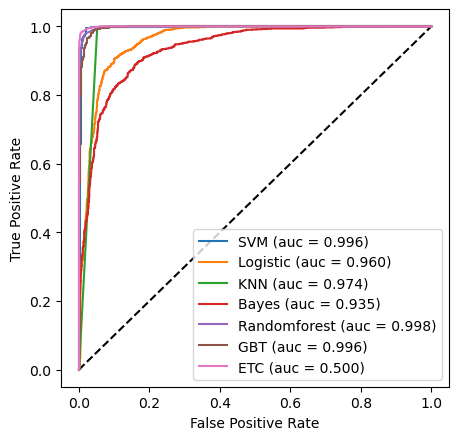

In [139]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
plt.plot(log_fpr, log_tpr, linestyle='-', label='Logistic (auc = %0.3f)' % auc_log)
plt.plot(knn_fpr, knn_tpr, linestyle='-', label='KNN (auc = %0.3f)' % auc_knn)
plt.plot(bayes_fpr, bayes_tpr, linestyle='-', label='Bayes (auc = %0.3f)' % auc_bayes)
plt.plot(forest_fpr, forest_tpr, linestyle='-', label='Randomforest (auc = %0.3f)' % auc_forest)
plt.plot(gbt_fpr, gbt_tpr, linestyle='-', label='GBT (auc = %0.3f)' % auc_gbt)
plt.plot(etc_fpr, etc_tpr, linestyle='-', label='ETC (auc = %0.3f)' % auc_etc)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='best')

From the ROC curve and our model scores we can see that our random forest model reigns supreme.

## Precision Recall Curve

Get precision and recall values for each model for graph

In [140]:
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred_svm)
log_precision, log_recall, _ = precision_recall_curve(y_test, y_pred_log)
knn_precision, knn_recall, _ = precision_recall_curve(y_test, y_pred_knn)
bayes_precision, bayes_recall, _ = precision_recall_curve(y_test, y_pred_bayes)
forest_precision, forest_recall, _ = precision_recall_curve(y_test, y_pred_forest)
gbt_precision, gbt_recall, _ = precision_recall_curve(y_test, y_pred_gbt)
etc_precision, etc_recall, _ = precision_recall_curve(y_test, y_pred_etc)

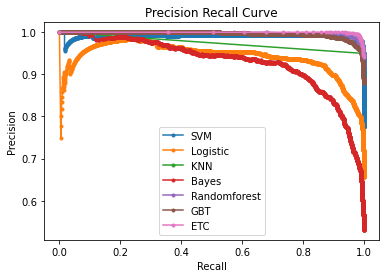

In [141]:
# plot the precision-recall curves
plt.plot(svm_recall, svm_precision, marker='.', label='SVM')
plt.plot(log_recall, log_precision, marker='.', label='Logistic')
plt.plot(knn_recall, knn_precision, marker='.', label='KNN')
plt.plot(bayes_recall, bayes_precision, marker='.', label='Bayes')
plt.plot(forest_recall, forest_precision, marker='.', label='Randomforest')
plt.plot(gbt_recall, gbt_precision, marker='.', label='GBT')
plt.plot(etc_recall, etc_precision, marker='.', label='ETC')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision Recall Curve')
plt.show()

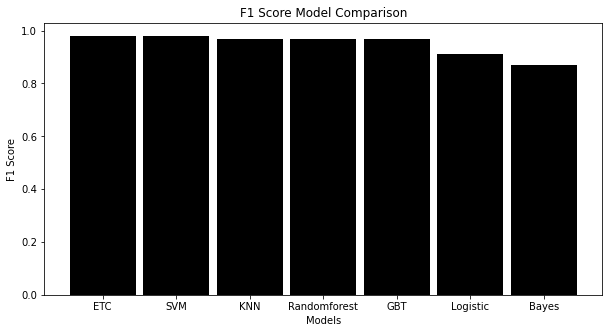

In [143]:
#F1 Score barplot
models = ['ETC','SVM','KNN','Randomforest','GBT','Logistic', 'Bayes']
f1_scores = [0.98,0.98,0.97,0.97,0.97,0.91,0.87]


fig = plt.figure(figsize = (10, 5))
plt.bar(models, f1_scores, color = 'black',
        width = 0.9)
 
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("F1 Score Model Comparison")
plt.show()

In [39]:
#The Kaggle competition is closed, but if we needed to output predictions
fin_y_pred = svm_pred
fin_submission = pd.DataFrame()
fin_submission['Bankrupt?'] = fin_y_pred
# fin_submission.to_csv('submission1.csv',index=False)